# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
    * Repeat addapted Version of using Build in methods for training, ...
    * Save models using keras
        * CaseNet first real model: check in implementation of Frey if a Layer needs to be written
        * other Example: depth seperable dilated convolution,
* Idea
    * Loss
        * Focal Loss: for imbalanced Data
        * In general Loss: just now weight in each dependent on number of Edge Pixels

# Libraries

TODO:
- Result better if "Fine Tuning" -> whole backbone frozen ?
- plot and compute results before and after training of the following:
- Metrics: widen and not of F1 for
    - test
    - test_advanced
- Images of the following
    - test
    - test_advanced
    - random more advanced and difficult (no GT)

In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
#import sys
import matplotlib.pyplot as plt




import DataProcessing.data_processing as data_processing
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.tools as tools


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#np.set_printoptions(threshold=sys.maxsize)

# Testing

# Options

In [6]:
#tf.config.run_functions_eagerly(True)

DATA = 'RealRed'
MODEL = 'CASENET_FOCAL_LOSS_0.85_REAL'
TRAIN_DS = 'Train'
TEST_DS = 'Test'
TEST_HARD_DS = 'Test Hard'
TEST_IMG_DS = 'Test IMG'
MODEL_LOADED = 'CASENET_FOCAL_LOSS_0.85'
HALF = True

IMG_SIZE_HEIGHT = 1280
IMG_SIZE_WIDTH = 720
NUM_CLASSES = 3
BATCH_SIZE = 8

MAX_IMG_TRAIN = 100
MAX_IMG_TEST = 25

CACHE = True
SEED = None

FINE_TUNING = False

EPOCHS = 5
fine_tune_epochs = 5

#Model Callback
MODEL_SAVE_EPOCH_FREQ = 5
DEL_OLD_CHECKPOINTS = False

# TENSORBOARD:
TENSORBOARD = False
DEL_OLD_TENSORBOARD = True

# SAVE
SAVE = False

# LOSS
weighted_multi_label_sigmoid_edge_loss = False
if weighted_multi_label_sigmoid_edge_loss:
    beta_upper = 0.95
    beta_lower = 0.05
    class_weighted = False

focal_loss = True
if focal_loss:
    gamma=2 
    alpha=1 
    weighted_beta=True 
    beta_upper=0.85 
    beta_lower=0.15
    class_weighted=False

#TESTING
test = False
if test:
    EPOCHS = 10
    MAX_IMG_TRAIN = 100
    MAX_IMG_TEST = 10

# Load Dataset, Preprocess Images and Dataset

In [5]:
tf.random.set_seed(SEED)

paths, files = data_processing.path_definitions(HALF, MODEL, DATA, TRAIN_DS, TEST_DS, TEST_HARD_DS, TEST_IMG_DS, MODEL_LOADED)

data_processing.clean_model_directories(paths, DEL_OLD_CHECKPOINTS, DEL_OLD_TENSORBOARD)

train_ds, img_count_train = data_processing.loader(paths,"TRAIN", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TRAIN)
train_ds = data_processing.dataset_processing(train_ds, cache=CACHE, shuffle=True, batch_size=BATCH_SIZE, prefetch=True, img_count=img_count_train)

test_ds, img_count_test = data_processing.loader(paths,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_ds = data_processing.dataset_processing(test_ds, cache=CACHE, shuffle=False, batch_size=BATCH_SIZE, prefetch=True, img_count=img_count_test)

test_hard_ds, img_count_test_hard = data_processing.loader(paths,"TEST_HARD", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_hard_ds = data_processing.dataset_processing(test_hard_ds, cache=False, shuffle=False, batch_size=BATCH_SIZE, prefetch=False, img_count=img_count_test_hard)

test_img_ds, img_count_test_img = data_processing.loader(paths,"IMG_ONLY", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST, has_mask=False)
test_img_ds = data_processing.dataset_processing(test_img_ds, cache=False, shuffle=False, batch_size=BATCH_SIZE, prefetch=False, img_count=img_count_test_img)

NameError: name 'DEL_OLD_CHECKPOINTS' is not defined

# Model

In [4]:
if weighted_multi_label_sigmoid_edge_loss:
    loss = lambda y_true, y_pred : losses.weighted_multi_label_sigmoid_loss(y_true,y_pred,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
elif focal_loss:
    loss = lambda y_true, y_pred : losses.focal_loss_edges(y_true, y_pred, gamma=gamma, alpha=alpha, weighted_beta=weighted_beta,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
else:
    raise ValueError("either FocalLoss or WeightedMultiLabelSigmoidLoss must be True")

custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                  "F1Edges": metrics.F1Edges,
                  "<lambda>":loss}

model = tf.keras.models.load_model(paths["MODEL LOADED"], custom_objects=custom_objects)

# Visual Results before Fine Tuning on Real World Data

## test dataset

2022-05-06 10:15:44.333811: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


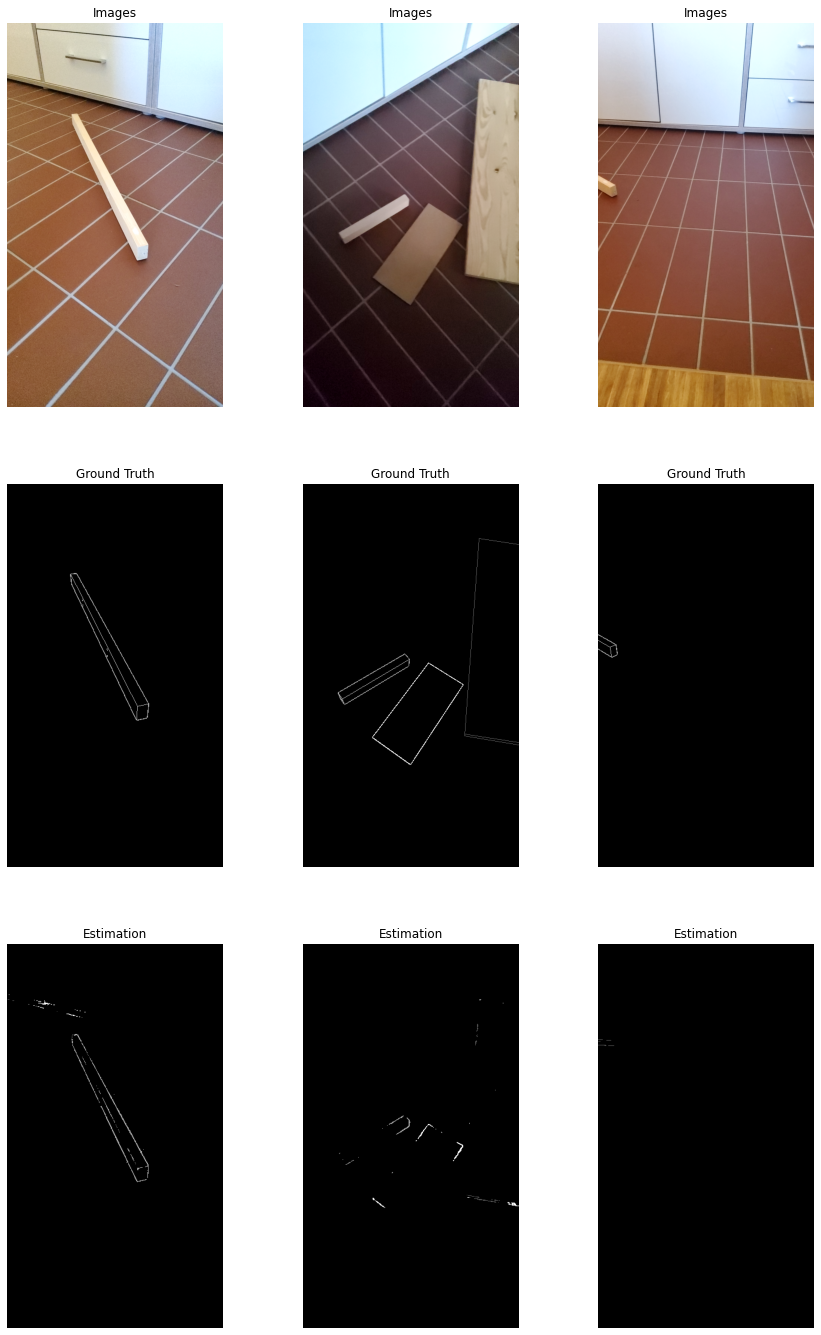

In [5]:
for img, label in test_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"pre_training_images_test")
tools.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

## test hard

In [ ]:
for img, label in test_hard_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"pre_training_images_test_hard")
tools.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

## test img

In [ ]:
for img in test_img_ds.take(1):
    img = img

predictions = model.predict(img)    
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"pre_training_images_test_img")
tools.plot_images(images=img, labels=None, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

# Metric Numerical Results before Fine Tuning on Real World Data

## test

In [ ]:
step_width = 0.05
threshold_range = [0.1,0.9]
threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"metric_test_pre_training_threshold{:.1f}.svg".format(0))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=0, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"metric_test_pre_training_threshold{:.1f}.svg".format(THRESHOLD_EDGE_WIDTH_REAL))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=THRESHOLD_EDGE_WIDTH_REAL, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

## test hard

In [ ]:
step_width = 0.05
threshold_range = [0.1,0.9]
threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"metric_test_hard_pre_training_threshold{:.1f}.svg".format(0))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_hard_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=0, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"metric_test_hard_pre_training_threshold{:.1f}.svg".format(THRESHOLD_EDGE_WIDTH_REAL))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_hard_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=THRESHOLD_EDGE_WIDTH_REAL, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

# Compile and Train Model

In [6]:
if TENSORBOARD:
    %load_ext tensorboard
    %tensorboard --logdir /home/david/SemesterProject/Models/CASENet/logs

In [7]:
# Fine-tune from this layer onwards
output_names = ["conv1_relu", "conv2_block3_out", "conv3_block4_out", "conv4_block23_out", "conv5_block3_out"])
fine_tune_output = output_names[4-1]

model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer: 
for submodel in model.layers:
    if submodel.name == "base_model":
        for layer in submodel.layers:
            layer.trainable = False
            if layer.name == fine_tune_output:
                break

                

# learning rate schedule
# base_learning_rate = 0.00125
base_learning_rate = 0.001
end_learning_rate = 0.0001
decay_step = np.ceil(img_count_train / BATCH_SIZE)*EPOCHS
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

frequency = int(np.ceil(img_count_train / BATCH_SIZE)*MODEL_SAVE_EPOCH_FREQ)

logdir = os.path.join(paths['TBLOGS'], datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = paths["CKPT"]+ "/ckpt-loss={loss:.2f}-epoch={epoch:.2f}",save_weights_only=False,save_best_only=False,monitor="val_loss",verbose=1,save_freq= frequency),
            tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)]

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=loss,
              metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                  metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds, callbacks=callbacks)

Epoch 1/5


TypeError: in user code:

    File "/home/david/SemesterProject/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_7710/2543272548.py", line 4, in None  *
        lambda y_true, y_pred : losses.FocalLossEdges(y_true, y_pred, gamma=gamma, alpha=alpha, weighted_beta=weighted_beta,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=classWeighted)

    TypeError: tf__FocalLossEdges() got an unexpected keyword argument 'beta_lower'


# training evolution

In [ ]:
plot_losses = ["loss", "output_loss"]
plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]

path = os.path.join(paths["FIGURES"],"training.svg")

tools.plot_training_results(res=history.history, losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path)


for img, label in test_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"training_images_test")
tools.plot_images(images=img, labels=label, predictions=predictions, save=False, path=path, batch_size=BATCH_SIZE)

# Fine Tuning

In [ ]:
if FINE_TUNING:

    # Fine-tune from this layer onwards
    fine_tune_output = output_names[2-1]

    model.trainable = True

    # Freeze all the layers before the `fine_tune_at` layer: 
    for submodel in model.layers:
        if submodel.name == "base_model":
            for layer in submodel.layers:
                layer.trainable = False
                if layer.name == fine_tune_output:
                    break
    
    
    total_epochs =  EPOCHS + fine_tune_epochs

    base_learning_rate = 0.00001
    end_learning_rate =  0.00001
    decay_step = np.floor(img_count_train / BATCH_SIZE)*fine_tune_epochs
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=loss,
                  metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})
    

    history_fine = model.fit(train_ds, epochs=total_epochs, 
                               initial_epoch=history.epoch[-1]+1,validation_data=train_ds.take(1), 
                               callbacks=callbacks)
    
    plot_losses = ["loss", "output_loss"]
    plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]
    
    path = os.path.join(paths["FIGURES"],"fine_tuning_training.svg")
    
    tools.plot_training_results(res=history.history, res_fine = history_fine.history, 
                                losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path, epochs=EPOCHS)

# Metric Numerical Results After Fine Tuning on Real World Data

## test

In [ ]:
step_width = 0.05
threshold_range = [0.1,0.9]
threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"metric_test_post_training_threshold{:.1f}.svg".format(0))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=0, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"metric_test_post_training_threshold{:.1f}.svg".format(THRESHOLD_EDGE_WIDTH_REAL))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=THRESHOLD_EDGE_WIDTH_REAL, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

## test hard

In [ ]:
step_width = 0.05
threshold_range = [0.1,0.9]
threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"metric_test_hard_post_training_threshold{:.1f}.svg".format(0))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_hard_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=0, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"metric_test_hard_post_training_threshold{:.1f}.svg".format(THRESHOLD_EDGE_WIDTH_REAL))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_hard_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=THRESHOLD_EDGE_WIDTH_REAL, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

# Visual Results After Fine Tuning on Real World Data

## test

In [ ]:
for img, label in test_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"post_training_images_test")
tools.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

## test hard

In [ ]:
for img, label in test_hard_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"post_training_images_test_hard")
tools.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

## test img

In [ ]:
for img in test_img_ds.take(1):
    img = img

predictions = model.predict(img)    
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"post_training_images_test_img")
tools.plot_images(images=img, labels=None, predictions=predictions, save=SAVE, path=path, batch_size=BATCH_SIZE)

# Save Model

In [ ]:
if SAVE:
    model.save(paths["MODEL"])
    
    custom_objects = {"BinaryAccuracy_Edges": metrics.BinaryAccuracy_Edges,
                      "Recall_Edges": metrics.Recall_Edges,
                      "Precision_Edges": metrics.Precision_Edges,
                      "lambda":loss}

# Addtional Elements to Consider in other Projects

* Data augmentation for small datasets